# Red Inicial


## Imports


In [1]:
from __future__ import annotations

from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.actions import Acciones
from custom_env.router_env import RouterEnv
from custom_env.states import NormalState, AttackState
from custom_env.utils import Color, Location
from gymnasium import make
from gymnasium.utils.env_checker import check_env
from pandas import DataFrame, Series
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor

Cargado a las 2025-05-23 18:25:08.724563


In [2]:
name = "./models/Example"
logs_path = "./logs/train/"
models_path = "./models/"
env_id = "RouterEnv-v0"

progress_bar = True
if progress_bar == True:
    import rich
    import tqdm

## Clases y Funciones


In [3]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones


def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun


def calcular_stats_acciones(acciones):
    if isinstance(acciones[-1], int):
        acciones = [Acciones.int_to_action(a) for a in acciones]
    print(f"{Acciones.DENEGAR.name}: {acciones.count(Acciones.DENEGAR)/len(acciones):.2%}")
    print(f"{Acciones.PERMITIR.name}: {acciones.count(Acciones.PERMITIR)/len(acciones):.2%}")

## Entrenamiento


In [ ]:
seed = None
env: RouterEnv = make(env_id, seed=seed)

check_env(env)

print("Seed: ", env._np_random_seed)

new_logger: Logger = configure(logs_path, ["stdout", "csv"])
env = Monitor(env, logs_path)


model: PPO = PPO("MultiInputPolicy", env,
                 verbose=True,)


model.set_logger(new_logger)
try:
    model.learn(total_timesteps=int(1e5//1),
                progress_bar=progress_bar)
except KeyboardInterrupt:
    print("Entrenamiento interrumpido")


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Seed:  103271443081218994839601088478951294948
Logging to ./logs/train/


Output()

Using cpu device
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 1.35e+03 |
| time/              |          |
|    fps             | 543      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.44e+03     |
| time/                   |              |
|    fps                  | 481          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0061543034 |
|    clip_fraction        | 0.0745       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.688       |
|    explained_variance   | -0.00224     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.49e+03     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00387     |
|    value_loss           | 6.93e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.16e+03    |
| time/                   |             |
|    fps                  | 465         |
|    iterations           | 3           |
|    time_elapsed         | 13          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.005002608 |
|    clip_fraction        | 0.0436      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | 0.00372     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.68e+03    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00456    |
|    value_loss           | 4.36e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 940          |
| time/                   |              |
|    fps                  | 471          |
|    iterations           | 4            |
|    time_elapsed         | 17           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 5.314972e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.67        |
|    explained_variance   | -0.000248    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.07e+03     |
|    n_updates            | 30           |
|    policy_gradient_loss | -1.18e-05    |
|    value_loss           | 8.54e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.09e+03     |
| time/                   |              |
|    fps                  | 470          |
|    iterations           | 5            |
|    time_elapsed         | 21           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0033872416 |
|    clip_fraction        | 0.0106       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.681       |
|    explained_variance   | 0.212        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.87e+03     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00136     |
|    value_loss           | 1.15e+04     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.2e+03     |
| time/                   |             |
|    fps                  | 472         |
|    iterations           | 6           |
|    time_elapsed         | 26          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.004861567 |
|    clip_fraction        | 0.022       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.675      |
|    explained_variance   | 0.346       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.51e+03    |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00231    |
|    value_loss           | 5.27e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.33e+03     |
| time/                   |              |
|    fps                  | 469          |
|    iterations           | 7            |
|    time_elapsed         | 30           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0029110436 |
|    clip_fraction        | 0.0454       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.659       |
|    explained_variance   | 0.422        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.14e+03     |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00479     |
|    value_loss           | 4.74e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.39e+03     |
| time/                   |              |
|    fps                  | 466          |
|    iterations           | 8            |
|    time_elapsed         | 35           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0019958573 |
|    clip_fraction        | 0.00459      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.647       |
|    explained_variance   | 0.318        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.9e+03      |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.000834    |
|    value_loss           | 5.79e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.3e+03     |
| time/                   |             |
|    fps                  | 466         |
|    iterations           | 9           |
|    time_elapsed         | 39          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.003333351 |
|    clip_fraction        | 0.0126      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.618      |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.7e+03     |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00188    |
|    value_loss           | 5.74e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.29e+03     |
| time/                   |              |
|    fps                  | 465          |
|    iterations           | 10           |
|    time_elapsed         | 43           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0023398655 |
|    clip_fraction        | 0.0296       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.626       |
|    explained_variance   | 0.412        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.93e+03     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00228     |
|    value_loss           | 1.65e+04     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 1.16e+03      |
| time/                   |               |
|    fps                  | 468           |
|    iterations           | 11            |
|    time_elapsed         | 48            |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 0.00040055273 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.63         |
|    explained_variance   | 0.47          |
|    learning_rate        | 0.0003        |
|    loss                 | 5.24e+03      |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.00098      |
|    value_loss           | 1.16e+04      |
-------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 1.06e+03   |
| time/                   |            |
|    fps                  | 467        |
|    iterations           | 12         |
|    time_elapsed         | 52         |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.01033894 |
|    clip_fraction        | 0.0659     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.654     |
|    explained_variance   | 0.475      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.91e+03   |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.00549   |
|    value_loss           | 1.81e+04   |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.05e+03     |
| time/                   |              |
|    fps                  | 469          |
|    iterations           | 13           |
|    time_elapsed         | 56           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0048787147 |
|    clip_fraction        | 0.0829       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.67        |
|    explained_variance   | 0.537        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.9e+03      |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00406     |
|    value_loss           | 1.35e+04     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.05e+03     |
| time/                   |              |
|    fps                  | 469          |
|    iterations           | 14           |
|    time_elapsed         | 61           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0012609216 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.662       |
|    explained_variance   | 0.608        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.7e+03      |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.000504    |
|    value_loss           | 8.51e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.1e+03     |
| time/                   |             |
|    fps                  | 469         |
|    iterations           | 15          |
|    time_elapsed         | 65          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.003968386 |
|    clip_fraction        | 0.0171      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.649      |
|    explained_variance   | 0.6         |
|    learning_rate        | 0.0003      |
|    loss                 | 5.45e+03    |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00476    |
|    value_loss           | 1.04e+04    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.14e+03    |
| time/                   |             |
|    fps                  | 470         |
|    iterations           | 16          |
|    time_elapsed         | 69          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.007006311 |
|    clip_fraction        | 0.0243      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.626      |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.74e+03    |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00208    |
|    value_loss           | 4.81e+03    |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 1.22e+03      |
| time/                   |               |
|    fps                  | 471           |
|    iterations           | 17            |
|    time_elapsed         | 73            |
|    total_timesteps      | 34816         |
| train/                  |               |
|    approx_kl            | 0.00080952223 |
|    clip_fraction        | 0.00767       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.62         |
|    explained_variance   | 0.729         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.07e+03      |
|    n_updates            | 160           |
|    policy_gradient_loss | -0.000934     |
|    value_loss           | 5.33e+03      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.22e+03    |
| time/                   |             |
|    fps                  | 467         |
|    iterations           | 18          |
|    time_elapsed         | 78          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.006989392 |
|    clip_fraction        | 0.0895      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.566      |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.83e+03    |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00636    |
|    value_loss           | 6.05e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.25e+03     |
| time/                   |              |
|    fps                  | 464          |
|    iterations           | 19           |
|    time_elapsed         | 83           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0006611652 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.583       |
|    explained_variance   | 0.759        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.71e+03     |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 6.01e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.26e+03     |
| time/                   |              |
|    fps                  | 461          |
|    iterations           | 20           |
|    time_elapsed         | 88           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0012393282 |
|    clip_fraction        | 0.0019       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.566       |
|    explained_variance   | 0.707        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.56e+03     |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00139     |
|    value_loss           | 5.72e+03     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 1.25e+03   |
| time/                   |            |
|    fps                  | 459        |
|    iterations           | 21         |
|    time_elapsed         | 93         |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 0.00449435 |
|    clip_fraction        | 0.0743     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.563     |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.12e+03   |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.00254   |
|    value_loss           | 4.95e+03   |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.3e+03      |
| time/                   |              |
|    fps                  | 458          |
|    iterations           | 22           |
|    time_elapsed         | 98           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0031691983 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.585       |
|    explained_variance   | 0.796        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.04e+03     |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00238     |
|    value_loss           | 4.09e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.31e+03    |
| time/                   |             |
|    fps                  | 457         |
|    iterations           | 23          |
|    time_elapsed         | 102         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.001340288 |
|    clip_fraction        | 0.00288     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.546      |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.26e+03    |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.000175   |
|    value_loss           | 5.03e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.41e+03     |
| time/                   |              |
|    fps                  | 457          |
|    iterations           | 24           |
|    time_elapsed         | 107          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0016467532 |
|    clip_fraction        | 0.00581      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.549       |
|    explained_variance   | 0.76         |
|    learning_rate        | 0.0003       |
|    loss                 | 2.43e+03     |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00138     |
|    value_loss           | 5.1e+03      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.4e+03      |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 25           |
|    time_elapsed         | 112          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0014431082 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.543       |
|    explained_variance   | 0.717        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.72e+03     |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 5.07e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.4e+03     |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 26          |
|    time_elapsed         | 116         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.001665503 |
|    clip_fraction        | 0.00337     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.94e+03    |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00188    |
|    value_loss           | 4.52e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.41e+03     |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 27           |
|    time_elapsed         | 121          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0058829966 |
|    clip_fraction        | 0.0737       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.53        |
|    explained_variance   | 0.463        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.98e+03     |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00372     |
|    value_loss           | 4.28e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 1.45e+03      |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 28            |
|    time_elapsed         | 125           |
|    total_timesteps      | 57344         |
| train/                  |               |
|    approx_kl            | 0.00038140273 |
|    clip_fraction        | 0.00581       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.505        |
|    explained_variance   | 0.742         |
|    learning_rate        | 0.0003        |
|    loss                 | 3.04e+03      |
|    n_updates            | 270           |
|    policy_gradient_loss | -0.00103      |
|    value_loss           | 6.01e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.48e+03     |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 29           |
|    time_elapsed         | 130          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0030483026 |
|    clip_fraction        | 0.0245       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.532       |
|    explained_variance   | 0.772        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.87e+03     |
|    n_updates            | 280          |
|    policy_gradient_loss | 8.16e-05     |
|    value_loss           | 4.22e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.55e+03    |
| time/                   |             |
|    fps                  | 455         |
|    iterations           | 30          |
|    time_elapsed         | 134         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.001243719 |
|    clip_fraction        | 0.0245      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.559      |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.7e+03     |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00264    |
|    value_loss           | 3.14e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.6e+03      |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 31           |
|    time_elapsed         | 139          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0016606596 |
|    clip_fraction        | 0.00708      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.489       |
|    explained_variance   | 0.715        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.24e+03     |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.000559    |
|    value_loss           | 5.1e+03      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.73e+03     |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 32           |
|    time_elapsed         | 143          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0015865904 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.488       |
|    explained_variance   | 0.715        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.26e+03     |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 4.76e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 1.75e+03      |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 33            |
|    time_elapsed         | 148           |
|    total_timesteps      | 67584         |
| train/                  |               |
|    approx_kl            | 0.00061718083 |
|    clip_fraction        | 0.0253        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.49         |
|    explained_variance   | 0.793         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.94e+03      |
|    n_updates            | 320           |
|    policy_gradient_loss | -0.000399     |
|    value_loss           | 4.21e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.77e+03     |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 34           |
|    time_elapsed         | 152          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0036532977 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.411       |
|    explained_variance   | 0.548        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.37e+03     |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00163     |
|    value_loss           | 5.38e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.77e+03     |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 35           |
|    time_elapsed         | 156          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0024156952 |
|    clip_fraction        | 0.00405      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.453       |
|    explained_variance   | 0.795        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.81e+03     |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 3.56e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.76e+03     |
| time/                   |              |
|    fps                  | 454          |
|    iterations           | 36           |
|    time_elapsed         | 162          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0012172501 |
|    clip_fraction        | 0.00513      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.426       |
|    explained_variance   | 0.635        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.97e+03     |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.000455    |
|    value_loss           | 4.2e+03      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.73e+03     |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 37           |
|    time_elapsed         | 167          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0026181084 |
|    clip_fraction        | 0.0339       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.46        |
|    explained_variance   | 0.386        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.01e+03     |
|    n_updates            | 360          |
|    policy_gradient_loss | 1.81e-05     |
|    value_loss           | 3.36e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.78e+03     |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 38           |
|    time_elapsed         | 172          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0006864015 |
|    clip_fraction        | 0.00542      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.424       |
|    explained_variance   | 0.697        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.91e+03     |
|    n_updates            | 370          |
|    policy_gradient_loss | 0.000137     |
|    value_loss           | 3.86e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.8e+03      |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 39           |
|    time_elapsed         | 176          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0048842016 |
|    clip_fraction        | 0.0491       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.423       |
|    explained_variance   | 0.309        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.12e+03     |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 3.72e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.82e+03     |
| time/                   |              |
|    fps                  | 453          |
|    iterations           | 40           |
|    time_elapsed         | 180          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0028294905 |
|    clip_fraction        | 0.0108       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.363       |
|    explained_variance   | 0.307        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.41e+03     |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00153     |
|    value_loss           | 4.53e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.86e+03     |
| time/                   |              |
|    fps                  | 453          |
|    iterations           | 41           |
|    time_elapsed         | 185          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0039283945 |
|    clip_fraction        | 0.0489       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.353       |
|    explained_variance   | 0.132        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.23e+03     |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.00259     |
|    value_loss           | 4.56e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.87e+03     |
| time/                   |              |
|    fps                  | 453          |
|    iterations           | 42           |
|    time_elapsed         | 189          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0034092152 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.399       |
|    explained_variance   | 0.483        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.74e+03     |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00166     |
|    value_loss           | 3.36e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 1.86e+03      |
| time/                   |               |
|    fps                  | 452           |
|    iterations           | 43            |
|    time_elapsed         | 194           |
|    total_timesteps      | 88064         |
| train/                  |               |
|    approx_kl            | 0.00089021365 |
|    clip_fraction        | 0.00371       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.401        |
|    explained_variance   | 0.493         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.52e+03      |
|    n_updates            | 420           |
|    policy_gradient_loss | 0.000247      |
|    value_loss           | 2.98e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.86e+03     |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 44           |
|    time_elapsed         | 199          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0003434394 |
|    clip_fraction        | 0.0183       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.339       |
|    explained_variance   | 0.449        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.25e+03     |
|    n_updates            | 430          |
|    policy_gradient_loss | 0.000202     |
|    value_loss           | 3.77e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.87e+03     |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 45           |
|    time_elapsed         | 203          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0035621477 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.378       |
|    explained_variance   | 0.477        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.63e+03     |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00171     |
|    value_loss           | 3.21e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.87e+03     |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 46           |
|    time_elapsed         | 208          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0029500886 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.337       |
|    explained_variance   | 0.561        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.39e+03     |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.000599    |
|    value_loss           | 3.93e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.88e+03    |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 47          |
|    time_elapsed         | 213         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.004301325 |
|    clip_fraction        | 0.0275      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.33       |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.99e+03    |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00229    |
|    value_loss           | 3.85e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.86e+03     |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 48           |
|    time_elapsed         | 217          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0054950416 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.326       |
|    explained_variance   | 0.542        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.45e+03     |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000473    |
|    value_loss           | 3.94e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.94e+03     |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 49           |
|    time_elapsed         | 221          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0020254878 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.39        |
|    explained_variance   | 0.688        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.67e+03     |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.000553    |
|    value_loss           | 3.01e+03     |
------------------------------------------


Modelo guardado


### Gráficas de Entrenamiento


Avaliable metrics:  ['rollout/ep_len_mean', 'time/total_timesteps', 'time/iterations', 'time/time_elapsed', 'rollout/ep_rew_mean', 'time/fps', 'train/entropy_loss', 'train/approx_kl', 'train/clip_fraction', 'train/explained_variance', 'train/n_updates', 'train/policy_gradient_loss', 'train/clip_range', 'train/value_loss', 'train/learning_rate', 'train/loss']


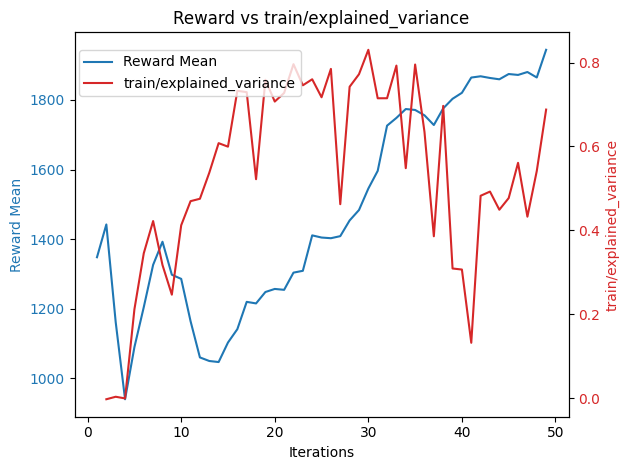

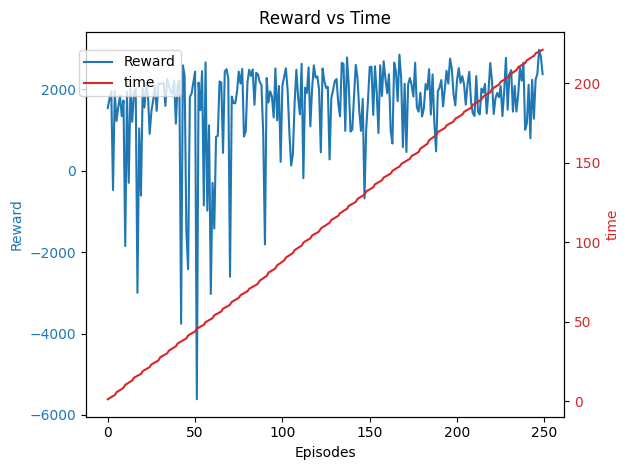

In [19]:
train_data_log: DataFrame = pd.read_csv(logs_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(logs_path+"monitor.csv", header=1)


print("Avaliable metrics: ", train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
color = Color.BLUE.value
ax1.set_ylabel('Reward Mean', color=color)
ax1.plot(iterations,
         train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
ax1.tick_params(axis='y', labelcolor=color)


col = 'train/explained_variance'

ax2 = ax1.twinx()
color = Color.RED.value
ax2.set_ylabel(col, color=color)
ax2.plot(iterations, train_data_log[col], color=color, label=col)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Reward vs ' + col)


fig.tight_layout()
fig.legend(loc=Location.UPPER_LEFT.value, bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))


ax1.set_xlabel('Episodes')
color = Color.BLUE.value
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
color = Color.RED.value
ax2.set_ylabel('time', color=color)
ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc=Location.UPPER_LEFT.value, bbox_to_anchor=(0.12, 0.9))

plt.show()

## Comprobación funcionamiento


In [20]:
seed = 289980628190634006122751570777790489191
env: RouterEnv = make(env_id, seed=seed)
seed: int = env.np_random_seed
model: PPO = PPO.load(name, print_system_info=True)

num_steps = 1
obs, _ = env.reset(seed=seed)
# Variables de información:

stats = []
rewards = []

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)

        stats.append(info["Stats"])
        rewards.append(reward)

        done: bool = done or terminated

    env.reset(seed=seed)
    step_counter += 1

# Debug
acciones = [x["Action"] for x in stats]
calcular_stats_acciones(acciones)

print(f"Seed: {env.np_random_seed}")

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

DENEGAR: 4.50%
PERMITIR: 95.50%
Seed: 289980628190634006122751570777790489191


In [21]:
assert len(acciones) != acciones.count(
    Acciones.DENEGAR), "Se han denegado todos los paquetes"
assert len(acciones) != acciones.count(
    Acciones.PERMITIR), "Se han permitido todos los paquetes"

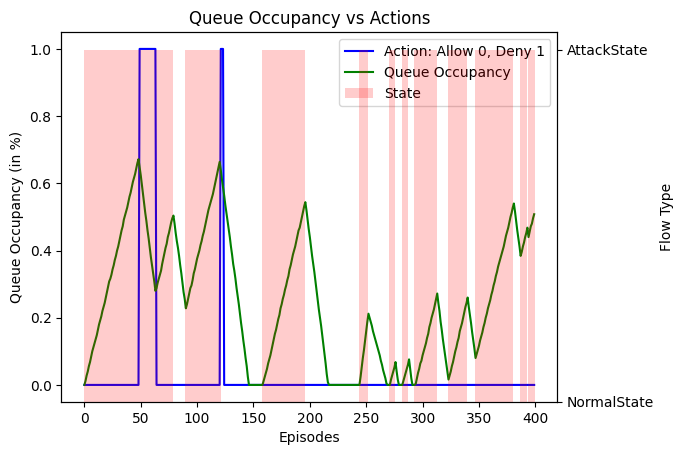

Rewards:  [8.5, 8.41, 8.29, 8.2, 8.08, 7.99, 7.87, 7.75, 7.66, 7.57, 7.48, 7.39, 7.27, 7.15, 7.06, 6.97, 6.85, 6.76, 6.67, 6.55, 6.43, 6.31, 6.19, 6.13, 6.04, 5.92, 5.83, 5.71, 5.62, 5.5, 5.41, 5.29, 5.17, 5.05, 4.96, 4.81, 4.72, 4.63, 4.54, 4.42, 4.3, 4.21, 4.09, 3.97, 3.88, 3.79, 3.67, 3.55, 3.46, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, 6.34, 6.22, 6.13, 6.04, 5.95, 5.8, 5.68, 5.56, 5.44, 5.35, 5.2, 5.11, 4.99, 4.87, 4.78, 4.72, 4.9, 5.11, 5.29, 5.44, 5.62, 5.83, 6.01, 6.22, 6.43, 6.58, 6.79, 6.7, 6.58, 6.46, 6.34, 6.28, 6.16, 6.01, 5.92, 5.8, 5.68, 5.59, 5.5, 5.38, 5.29, 5.17, 5.08, 4.96, 4.84, 4.72, 4.6, 4.51, 4.42, 4.33, 4.24, 4.12, 4.0, 3.88, 3.76, 3.64, 3.52, -2.0, -2.0, 3.09, 4.27, 4.48, 4.66, 4.84, 5.02, 5.2, 5.41, 5.59, 5.8, 5.95, 6.13, 6.34, 6.52, 6.7, 6.91, 7.12, 7.3, 7.51, 7.69, 7.9, 8.08, 8.32, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.41, 8.32, 8.23, 8.14, 8.02, 7.93, 7.84, 7.72, 7.6, 7.48, 7.36, 

In [22]:
assert len(acciones) == len(rewards)

fig, ax1 = plt.subplots()
ocu = [x["OcupacionActual"] for x in stats]
att = 1
norm = 0
NormalState
estados: list[int] = [norm if x["EstadoMaquina"] ==
                      NormalState.__name__ else att for x in stats]

acciones: list[int] = [Acciones.action_to_int(x["Action"]) for x in stats]

ax1.plot(
    acciones, label=f"Action: Allow {Acciones.action_to_int(Acciones.PERMITIR)}, Deny {Acciones.action_to_int(Acciones.DENEGAR)}", color='#0000FF')
ax1.plot(ocu, label="Queue Occupancy", color='green')
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Queue Occupancy (in %)")
ax1.set_title("Queue Occupancy vs Actions")

ax2 = ax1.twinx()
ax2.bar(range(len(estados)), estados, color='red',
        label="State", alpha=0.20, width=1)
ax2.set_ylabel("Flow Type")
ax2.set_yticks([0, 1],[NormalState.__name__, AttackState.__name__])

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.show()


print("Rewards: ", rewards)
calcular_stats_acciones(acciones)

Ocupación:  [0.0, 0.012, 0.028, 0.04, 0.056, 0.068, 0.084, 0.1, 0.112, 0.124, 0.136, 0.148, 0.164, 0.18, 0.192, 0.204, 0.22, 0.232, 0.244, 0.26, 0.276, 0.292, 0.308, 0.316, 0.328, 0.344, 0.356, 0.372, 0.384, 0.4, 0.412, 0.428, 0.444, 0.46, 0.472, 0.492, 0.504, 0.516, 0.528, 0.544, 0.56, 0.572, 0.588, 0.604, 0.616, 0.628, 0.644, 0.66, 0.672, 0.648, 0.624, 0.596, 0.568, 0.54, 0.512, 0.488, 0.46, 0.436, 0.408, 0.38, 0.356, 0.332, 0.308, 0.28, 0.288, 0.304, 0.316, 0.328, 0.34, 0.36, 0.376, 0.392, 0.408, 0.42, 0.44, 0.452, 0.468, 0.484, 0.496, 0.504, 0.48, 0.452, 0.428, 0.408, 0.384, 0.356, 0.332, 0.304, 0.276, 0.256, 0.228, 0.24, 0.256, 0.272, 0.288, 0.296, 0.312, 0.332, 0.344, 0.36, 0.376, 0.388, 0.4, 0.416, 0.428, 0.444, 0.456, 0.472, 0.488, 0.504, 0.52, 0.532, 0.544, 0.556, 0.568, 0.584, 0.6, 0.616, 0.632, 0.648, 0.664, 0.64, 0.612, 0.588, 0.564, 0.536, 0.512, 0.488, 0.464, 0.44, 0.412, 0.388, 0.36, 0.34, 0.316, 0.288, 0.264, 0.24, 0.212, 0.184, 0.16, 0.132, 0.108, 0.08, 0.056, 0.024, 0

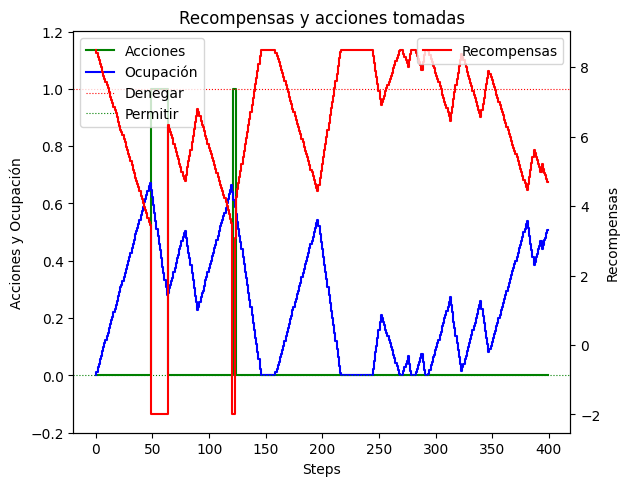

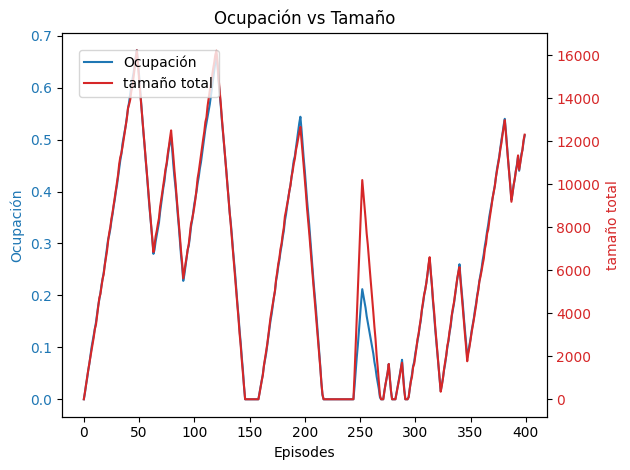

La ocupación máxima es de 67%
La ocupación mínima es de 0%


In [23]:
print("Ocupación: ", ocu)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

ax1.step(range(len(acciones)), acciones,
         label="Acciones", where='post', color='green')
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid', color='blue')


ticks = list(ax1.get_yticks())  

ax1.set_yticks(sorted(ticks)) 


ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red',
            linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR),
            color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


ax1.legend(loc=Location.UPPER_LEFT.value)

ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards,
         label="Recompensas", where='mid', color='r')

ax2.legend(loc=Location.UPPER_RIGHT.value)

fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam = [x["TamañoTotal"] for x in stats]


fig, ax1 = plt.subplots()

train_data_monitor: DataFrame = pd.read_csv(logs_path+"monitor.csv", header=1)

episodes = range(len(train_data_monitor['l']))

ax1.set_xlabel('Episodes')
color = Color.BLUE.value
label = 'Ocupación'
ax1.set_ylabel(label, color=color)
ax1.plot(range(len(ocu)), ocu, color=color, label=label)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Ocupación vs Tamaño')


ax2 = ax1.twinx()
color = Color.RED.value
label = 'tamaño total'
ax2.set_ylabel(label, color=color)
ax2.plot(range(len(tam)), tam, color=color, label=label)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc=Location.UPPER_LEFT.value, bbox_to_anchor=(0.12, 0.9))

plt.show()

print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación mínima es de {np.min(ocu):.0%}")